## Importing Kaggle Image Dataset in Colab

In [ ]:
# Enter the following code in a Colab cell
!pip install kaggle --upgrade

In [ ]:
from google.colab import files
files.upload()
# Click the file selection button and upload the kaggle.json file

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lloydkimyg","key":"c9531d13a060fc7501c555066cb5fb4c"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!ls -1ha kaggle.json

kaggle.json


In [ ]:
!kaggle datasets download -d maciejgronczynski/biggest-genderface-recognition-dataset

Dataset URL: https://www.kaggle.com/datasets/maciejgronczynski/biggest-genderface-recognition-dataset
License(s): CC0-1.0
 99% 436M/439M [00:25<00:00, 21.0MB/s]
100% 439M/439M [00:25<00:00, 17.7MB/s]


In [ ]:
from zipfile import ZipFile
file_name = 'biggest-genderface-recognition-dataset.zip'
with ZipFile(file_name, 'r') as zip:
  zip.extractall('/content/faces')
  print('Done')

Done


## Install the necessary libraries

In [ ]:
import numpy as np
import pandas as pd
from glob import glob
import os
import PIL
import tensorflow as tf
import pathlib
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split

In [ ]:
labels = []
image_count = []

for g in glob('./faces/faces/*'):
    print('----', g)
    for m in glob(g + '/*'):
        labels.append(g.split('/')[-1])
        image_count.append(m)

print(len(labels), len(image_count))

---- ./faces/faces/man
---- ./faces/faces/woman
27167 27167


In [ ]:
# Convert labels to numbers

import numpy as np

label_to_index = {}
index_to_label = {}

for i, label in enumerate(set(labels)):
    label_to_index[label] = i
    index_to_label[i] = label
print(label_to_index)

labels = [label_to_index[label] for label in labels]
print(labels[:10], type(labels))

labels = np.array(labels)
print(labels[:10], type(labels))

{'man': 0, 'woman': 1}
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0] <class 'list'>
[0 0 0 0 0 0 0 0 0 0] <class 'numpy.ndarray'>


In [ ]:
# Check how many images there are for each label

from collections import Counter

Counter(labels)

Counter({0: 17678, 1: 9489})

In [ ]:
# Check if all images are the same size
# Check if the aspect ratios are the same

from PIL import Image

sizes = []
for i in image_count:
    img = Image.open(i)
    sizes.append(img.size)

print(Counter(sizes))

Counter({(250, 250): 13230, (100, 100): 11630, (67, 86): 4, (106, 146): 4, (113, 147): 4, (109, 147): 3, (94, 123): 3, (80, 110): 3, (157, 204): 3, (88, 125): 3, (121, 154): 3, (116, 157): 3, (101, 134): 3, (101, 129): 3, (82, 108): 3, (70, 92): 3, (184, 261): 3, (55, 76): 3, (141, 194): 3, (157, 209): 3, (130, 173): 3, (74, 98): 3, (62, 87): 2, (125, 175): 2, (131, 173): 2, (127, 180): 2, (132, 177): 2, (96, 142): 2, (255, 350): 2, (187, 241): 2, (41, 52): 2, (90, 116): 2, (120, 158): 2, (208, 263): 2, (122, 164): 2, (112, 162): 2, (290, 384): 2, (67, 81): 2, (103, 142): 2, (87, 125): 2, (67, 90): 2, (148, 208): 2, (114, 154): 2, (164, 215): 2, (433, 583): 2, (84, 109): 2, (54, 79): 2, (218, 298): 2, (149, 202): 2, (50, 76): 2, (100, 135): 2, (76, 96): 2, (250, 359): 2, (160, 221): 2, (98, 130): 2, (140, 180): 2, (152, 195): 2, (130, 169): 2, (268, 370): 2, (128, 175): 2, (129, 172): 2, (128, 160): 2, (164, 207): 2, (101, 132): 2, (96, 130): 2, (196, 266): 2, (131, 170): 2, (83, 121):

Since the image sizes vary, I will be resizing all the images into a common size of 100 * 100 to ensure uniformity.

In [ ]:
from tqdm import tqdm

# Read the image files and convert them into numpy arrays
images = []

for i in tqdm(image_count):
    img = Image.open(i)
    img = img.resize((100, 100))
    img = np.array(img)

    images.append(img)

images = np.array(images)

print(images.shape)

100%|██████████| 27167/27167 [00:43<00:00, 622.29it/s]


(27167, 100, 100, 3)


In [ ]:
# Find the maximum and minimum pixel values in the 100x100x3 images
print(images.min(), images.max())

0 255


In [ ]:
# Split the data into training set, validation set, and test set
from sklearn.model_selection import train_test_split
train_input, rest_input, train_target, rest_target = train_test_split(
    images, labels, test_size=0.4, stratify=labels, random_state=42)

val_input, test_input, val_target, test_target = train_test_split(
    rest_input, rest_target, test_size=0.5, stratify=rest_target, random_state=42)

print(train_input.shape, val_input.shape, test_input.shape)
print(len(train_target), len(val_target), len(test_target))

(16300, 100, 100, 3) (5433, 100, 100, 3) (5434, 100, 100, 3)
16300 5433 5434


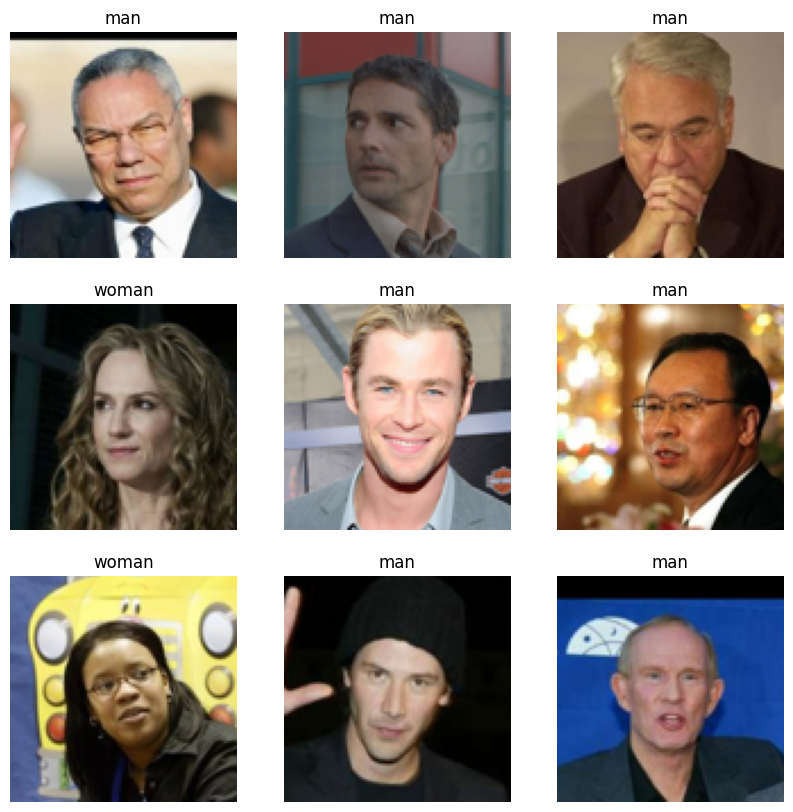

In [ ]:
# Check sample images
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(train_input[i].astype("uint8"))
    plt.title('man' if train_target[i] == 0 else 'woman')
    plt.axis("off")

## Create a Convolutional Neural Network (CNN)

In [ ]:
# 1. Optimize the data pipeline performance using Autotune
AUTOTUNE = tf.data.AUTOTUNE

# Convert NumPy arrays to TensorFlow Dataset objects
# Create a Dataset by combining train_input and train_target
train_dataset = tf.data.Dataset.from_tensor_slices((train_input, train_target))
val_dataset = tf.data.Dataset.from_tensor_slices((val_input, val_target))

# Apply cache, shuffle, and prefetch to the Dataset object
train_ds = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# Convert the Dataset object back to NumPy arrays if necessary (e.g., when using for model training)
# train_input_array = np.array(list(train_dataset.as_numpy_iterator()))
# val_input_array = np.array(list(val_dataset.as_numpy_iterator()))

In [ ]:
# 2. Improve the stability and speed of neural network training through normalization
# Create a layer for normalizing pixel values
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
# Normalize the training dataset
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.054901965 0.9607844


In [ ]:
# 3. Prevent overfitting through Data Augmentation
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(100, 100, 3)), # 이미지 크기 (100, 100), RGB:3
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

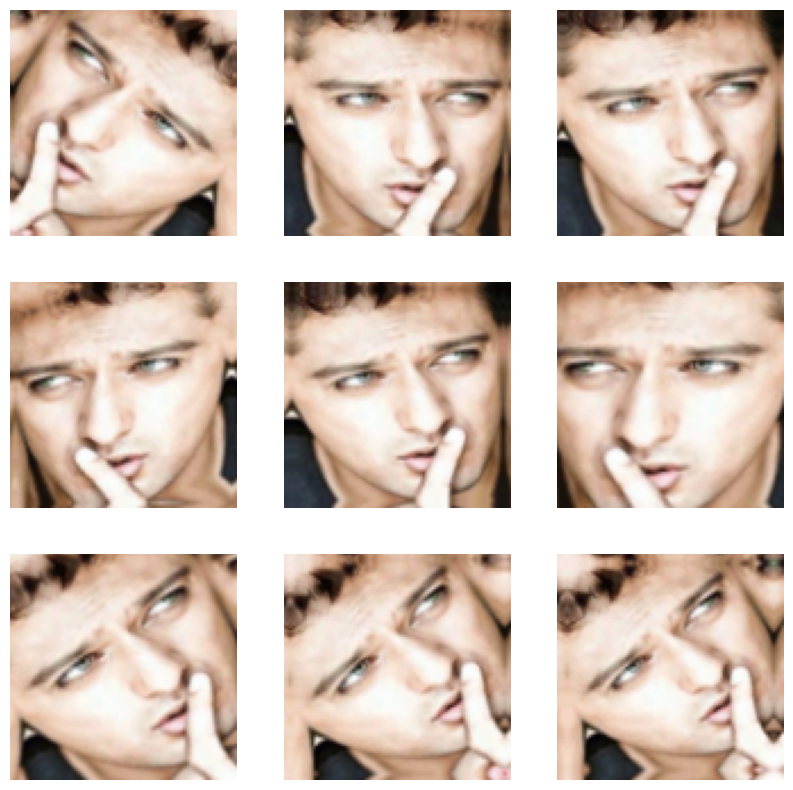

In [ ]:
# Apply Data Augmentation to the training dataset

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  # Add a batch dimension to 'images'
  images = tf.expand_dims(images, axis=0)
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


In [ ]:
# Create a Convolutional Neural Network (CNN) model
model = keras.Sequential([
  data_augmentation,                                          # Enhance performance through data augmentation
  keras.layers.experimental.preprocessing.Rescaling(1./255),  # Enhance performance through data normalization
  keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Flatten(),                      # Flatten the 3D feature map into a 1D vector
  keras.layers.Dense(128, activation='relu'),  # Create a hidden layer
  keras.layers.Dropout(0.2),                   # Prevent overfitting in hidden layers using Dropout
  keras.layers.Dense(2, activation='softmax')  # Create the output layer
])

In [ ]:
# Check the structure and the number of parameters of the Keras model
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (None, 100, 100, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 100, 100, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 50, 50, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 25, 25, 32)        0         
 g2D)                                                 

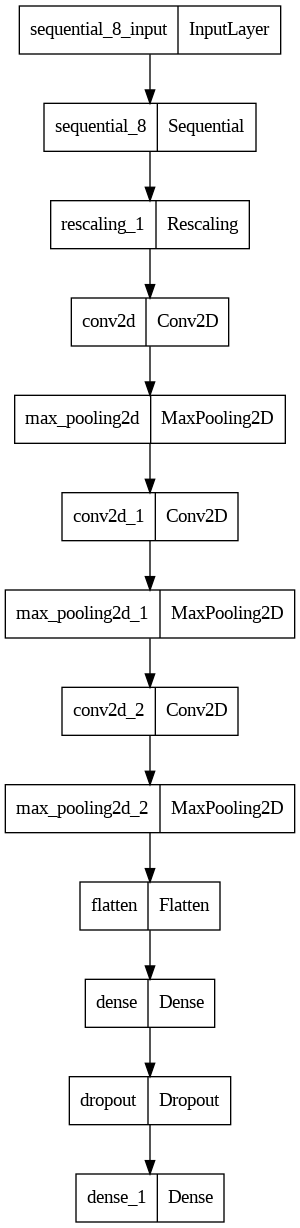

In [ ]:
# Visualize the structure of the Keras model
keras.utils.plot_model(model)

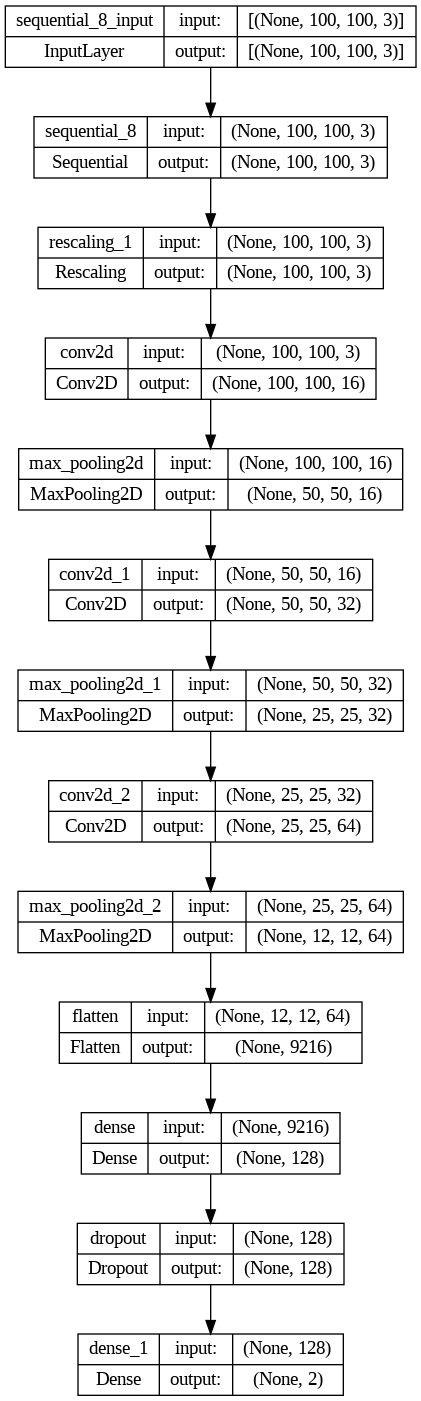

In [ ]:
# visualize the structure of the Keras model with input and output sizes: show_shapes=True
keras.utils.plot_model(model, show_shapes=True)

## Model Compile & Fit

In [ ]:
# Use the Adam optimizer, and utilize both the ModelCheckpoint callback and the EarlyStopping callback
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',
              metrics='accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.h5', # ModelCheckpoint: Save the model at each epoch
                                                save_best_only=True) # save_best_only=True: Select the model that produces the lowest validation score at each epoch
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,        # patience=2: Stop training if the validation score does not improve for 2 consecutive epochs
                                                  restore_best_weights=True) # estore_best_weights=True: Restore model weights from the epoch that produced the lowest validation score
history = model.fit(train_input, train_target, epochs=20,
                    validation_data=(val_input, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/20
510/510 [==============================] - 205s 397ms/step - loss: 0.4847 - accuracy: 0.7655 - val_loss: 0.3913 - val_accuracy: 0.8246
Epoch 2/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


510/510 [==============================] - 200s 392ms/step - loss: 0.3934 - accuracy: 0.8242 - val_loss: 0.3373 - val_accuracy: 0.8570
Epoch 3/20
510/510 [==============================] - 221s 434ms/step - loss: 0.3353 - accuracy: 0.8564 - val_loss: 0.3118 - val_accuracy: 0.8730
Epoch 4/20
510/510 [==============================] - 203s 399ms/step - loss: 0.3103 - accuracy: 0.8699 - val_loss: 0.2841 - val_accuracy: 0.8883
Epoch 5/20
510/510 [==============================] - 207s 405ms/step - loss: 0.2890 - accuracy: 0.8791 - val_loss: 0.2667 - val_accuracy: 0.8877
Epoch 6/20
510/510 [==============================] - 204s 400ms/step - loss: 0.2723 - accuracy: 0.8904 - val_loss: 0.2595 - val_accuracy: 0.8916
Epoch 7/20
510/510 [==============================] - 208s 407ms/step - loss: 0.2572 - accuracy: 0.8966 - val_loss: 0.2326 - val_accuracy: 0.9087
Epoch 8/20
510/510 [==============================] - 208s 408ms/step - loss: 0.2494 - accuracy: 0.8981 - val_loss: 0.2210 - val_accura

Optimization occurs at the 14th epoch

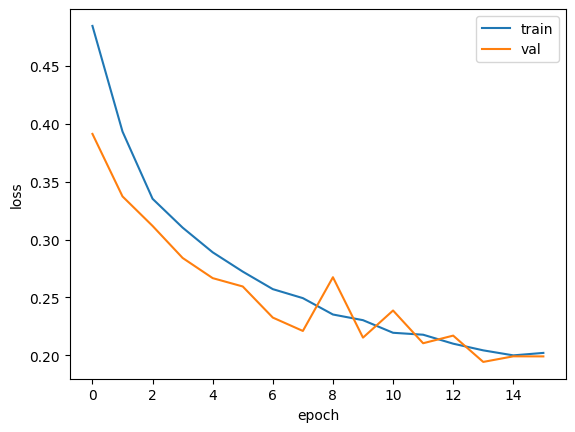

In [ ]:
# Plot the loss graph to verify if early stopping worked correctly
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

# Best performance achieved at the 14th epoch

In [ ]:
# Evaluate the performance on the validation set
model.evaluate(val_input, val_target)

# Same as the output from the 14th epoch

170/170 [==============================] - 17s 98ms/step - loss: 0.1943 - accuracy: 0.9244


[0.19426988065242767, 0.9243512153625488]

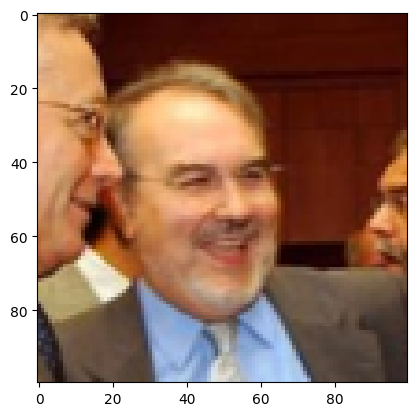

In [ ]:
# View the first image sample from the validation set
plt.imshow(val_input[0].reshape(100,100,3))
plt.show()

In [ ]:
# Use the predict() method to check the predictions for the 2 classes
preds = model.predict(val_input[0:1]) # Calculate the probability for the prediction of the first image in the validation set using slicing in Keras
print(preds)

1/1 [==============================] - 0s 247ms/step
[[0.9960776  0.00392239]]


99% probability of being male

In [ ]:
test_scaled = test_input.reshape(-1, 100, 100, 3) / 255.0

In [ ]:
model.evaluate(test_scaled, test_target)

# The test set scores are significantly lower than the validation set scores

170/170 [==============================] - 17s 98ms/step - loss: 0.8121 - accuracy: 0.6507


[0.8120639324188232, 0.6507176756858826]